# 0.Introduction
This tutorial will prepare all the prerequisites for running the homework program. If you are familiar with
google colab and gym environment please feel free to skip this tutorial.

#1.Setup
First, we will install Gym environment. Gym is a standard API for reinforcement learning developed by OpenAI, and a diverse collection of reference environments

In [ ]:
!pip install gymnasium #all development of Gym has been moved to Gymnasium

Then we will install Stable-Baselines3. 

Stable Baselines3 (SB3) is a set of reliable implementations of reinforcement learning algorithms in PyTorch, developed by German Aerospace Center (DLR)

In [ ]:
!pip install "stable-baselines3[extra]>=2.0.0a4"

# 2.The cart pole environment
This environment is part of the Classic Control environments.  A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

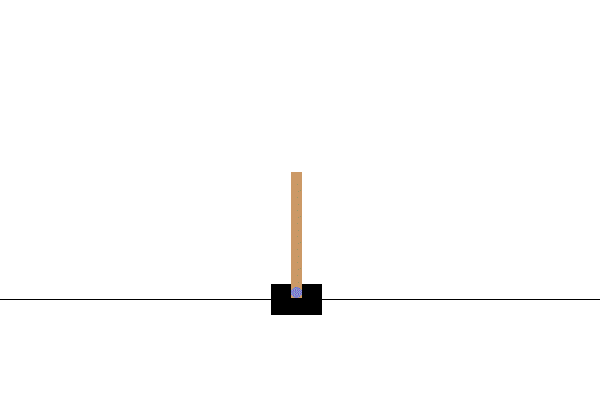


    Observation:
        Type: Box(4)
        Num    Observation               Min            Max
        0      Cart Position              -4.8           4.8
        1      Cart Velocity              -Inf          Inf
        2      Pole Angle                -0.418 rad(-24°) 0.418 rad(24°)
        3      Pole Angular Velocity     -Inf           Inf
    Actions:
        Type: Discrete(2)
        Num    Action
        0      Push cart to the Left
        1      Push cart to the Right
      Note: The velocity that is reduced or increased by the applied force is not fixed and it depends on the angle the pole is pointing. The center of gravity of the pole varies the amount of energy needed to move the cart underneath it
    Reward:
      Since the goal is to keep the pole upright for as long as possible, a reward of +1 for every step taken, including the termination step, is allotted. The threshold for rewards is 475 for v1.
    Starting State:
      All observations are assigned a uniformly random value in (-0.05, 0.05)
    Episode Termination:
      The episode ends if any one of the following occurs:
      1.Termination: Pole Angle is greater than ±12°
      2.Termination: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
      3.Truncation: Episode length is greater than 500 (200 for v0)

Create environment

In [3]:
import gymnasium as gym
env = gym.make("CartPole-v1", render_mode="rgb_array")

# 3.Training and evalution

Import Deep Q-learning (DQN) algorithm

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy

tensorboard_log = "data/tb/" #used for tensorboard

Create the DQN agent with tuned hyperparameters from RL Baseline3 zoo

RL Baselines3 Zoo is a training framework for Reinforcement Learning (RL), using Stable Baselines3. It provides scripts for training, evaluating agents, tuning hyperparameters, plotting results and recording videos. In addition, it includes a collection of tuned hyperparameters for common environments and RL algorithms, and agents trained with those settings.


```yaml
CartPole-v1:
  n_timesteps: !!float 5e4
  policy: 'MlpPolicy'
  learning_rate: !!float 2.3e-3
  batch_size: 64
  buffer_size: 100000
  learning_starts: 1000
  gamma: 0.99
  target_update_interval: 10
  train_freq: 256
  gradient_steps: 128
  exploration_fraction: 0.16
  exploration_final_eps: 0.04
  policy_kwargs: "dict(net_arch=[256, 256])"
```

Apply the tuned hyperparameters 

In [5]:
dqn_model = DQN(
    "MlpPolicy",
    env,
    verbose=1,
    train_freq=256,
    gradient_steps=128,
    gamma=0.99,
    exploration_fraction=0.16,
    exploration_final_eps=0.04,
    target_update_interval=10,
    learning_starts=1000,
    buffer_size=100000,
    batch_size=64,
    learning_rate=2.3e-3,
    policy_kwargs=dict(net_arch=[256, 256]),
    tensorboard_log=tensorboard_log,
    seed=0,
) 

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Evaluate the performance of the agent before training

In [ ]:
mean_reward, std_reward = evaluate_policy(
    dqn_model,
    dqn_model.get_env(),
    deterministic=True,
    n_eval_episodes=20,
)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

Train the agent

In [ ]:
dqn_model.learn(total_timesteps=50000, log_interval=5) #5e4

Evaluate the agent after training

In [ ]:
mean_reward, std_reward = evaluate_policy(dqn_model, dqn_model.get_env(), deterministic=True, n_eval_episodes=20)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

Monitor training in tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir $tensorboard_log

# 4.Video recording and showing
We will record a video using the VecVideoRecorder wrapper

In [10]:
# Set up fake display; otherwise rendering will fail
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [11]:
import base64
from pathlib import Path

from IPython import display as ipythondisplay


def show_videos(video_path="", prefix=""):
    """
    Taken from https://github.com/eleurent/highway-env

    :param video_path: (str) Path to the folder containing videos
    :param prefix: (str) Filter the video, showing only the only starting with this prefix
    """
    html = []
    for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append(
            """<video alt="{}" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>""".format(
                mp4, video_b64.decode("ascii")
            )
        )
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

In [12]:
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv


def record_video(
    env_id,
    model,
    video_length=500,
    prefix="",
    video_folder="videos/",
):
    """
    :param env_id: (str)
    :param model: (RL model)
    :param video_length: (int)
    :param prefix: (str)
    :param video_folder: (str)
    """
    eval_env = DummyVecEnv([lambda: gym.make(env_id, render_mode="rgb_array")])
    # Start the video at step=0 and record 500 steps
    eval_env = VecVideoRecorder(
        eval_env,
        video_folder=video_folder,
        record_video_trigger=lambda step: step == 0,
        video_length=video_length,
        name_prefix=prefix,
    )

    obs = eval_env.reset()
    for _ in range(video_length):
        action, _ = model.predict(obs, deterministic=False)
        obs, _, _, _ = eval_env.step(action)

    # Close the video recorder
    eval_env.close()

Visualize trained agent

In [ ]:
record_video("CartPole-v0", dqn_model, video_length=500, prefix="dqn-cartpole")

In [ ]:
show_videos("videos", prefix="dqn")

# References

Gym:  https://gymnasium.farama.org/

Stable-Baselines3: https://github.com/DLR-RM/stable-baselines3

Documentation: https://stable-baselines.readthedocs.io/en/master/

Stable-Baselines3-zoo: https://github.com/DLR-RM/rl-baselines3-zoo

Stable-Baselines-Team/rl-colab-notebooks: https://github.com/Stable-Baselines-Team/rl-colab-notebooks




